In [1]:
# 필요한 라이브러리를 import하기
from os import listdir
from os.path import join
import random
import matplotlib.pyplot as plt
%matplotlib inline

import os
import time
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_pil_image

# device 할당하기
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Github에 upload된 facade dataset을 다운로드 받는다
!git clone https://github.com/mrzhu-cool/pix2pix-pytorch # Git clone : 원격 저장소의 데이터를 가져오는 것을 의미한다
!mkdir 'data' # Dataset을 저장할 디렉토리 생성
!unzip /content/pix2pix-pytorch/dataset/facades.zip  -d /content/data; # 압축 풀기

Cloning into 'pix2pix-pytorch'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 68 (delta 17), reused 14 (delta 14), pack-reused 45
Unpacking objects: 100% (68/68), done.
Archive:  /content/pix2pix-pytorch/dataset/facades.zip
   creating: /content/data/facades/
   creating: /content/data/facades/test/
   creating: /content/data/facades/test/a/
  inflating: /content/data/facades/test/a/cmp_b0001.png  
  inflating: /content/data/facades/test/a/cmp_b0002.png  
  inflating: /content/data/facades/test/a/cmp_b0003.png  
  inflating: /content/data/facades/test/a/cmp_b0004.png  
  inflating: /content/data/facades/test/a/cmp_b0013.png  
  inflating: /content/data/facades/test/a/cmp_b0023.png  
  inflating: /content/data/facades/test/a/cmp_b0026.png  
  inflating: /content/data/facades/test/a/cmp_b0028.png  
  inflating: /content/data/facades/test/a/cmp_b0034.png  
  inflating: /content/data/facad

In [3]:
# facade데이터를 불러올 Custom Dataset 클래스를 생성한다
# Custom Dataset에는 반드시 __init__, __getitem__, __len__ 메소드가 overriding되어야 한다
# train/test디렉토리 내에 존재하는 b 디렉토리에 있는 사진을 입력하면 
# train/test디렉토리 내의 a 디렉토리의 사진으로 변환되도록 생성자를 훈련시킬 것이다.
# 즉 train/test 디렉토리의 b에는 조건 이미지가, a에는 정답 이미지가 들어있다

class FacadeDataset(Dataset):
  def __init__(self, path2img, direction='b2a', transform=False):
    super().__init__()
    self.direction = direction
    self.path2a = join(path2img, 'a')
    self.path2b = join(path2img, 'b')
    self.img_filenames = [x for x in listdir(self.path2a)]
    self.transform = transform

  def __getitem__(self, index):
    a = Image.open(join(self.path2a, self.img_filenames[index])).convert('RGB')
    b = Image.open(join(self.path2b, self.img_filenames[index])).convert('RGB')

    if self.transform:
      a = self.transform(a)
      b = self.transform(b)

    if self.direction == 'b2a':
      return b,a
    else:
      return a,b

  def __len__(self):
    return len(self.img_filenames)

In [4]:
# Dataset을 불러올 때 적용할 Pre-processor를 정의한다
transform = transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]),
          transforms.Resize((256,256))
])

In [5]:
# Dataset을 불러온다
path2img = "/content/data/facades/train"
train_ds = FacadeDataset(path2img, transform = transform)

(-0.5, 255.5, 255.5, -0.5)

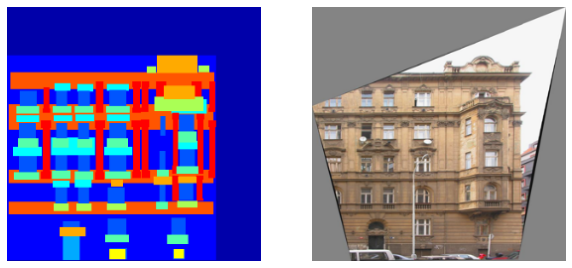

In [6]:
# Sample Image를 출력해보자
a,b = train_ds[0]
plt.figure(figsize=(10,10))

# 첫 번째로 보조이미지 출력하기
plt.subplot(1,2,1)
plt.imshow(to_pil_image(0.5*a+0.5))
plt.axis('off')

# 두 번째로 정답 이미지 출력하기
plt.subplot(1,2,2)
plt.imshow(to_pil_image(0.5*b+0.5))
plt.axis('off')

pix2pix의 목표는 왼쪽과 같은 이미지를 입력하여 오른쪽과 같은 이미지를 출력하는 것을 목표로 한다

In [7]:
# Data를 Batchsize만큼 불러올 DataLoader를 생성하기
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)

In [8]:
# 본격적으로 모델을 구축하자
# pix2pix의 Generator를 구현한다.
# Generator은 이미지 출력 성능을 높이기 위하여 UNet구조로 설계한다
# 다음은 UNet의 Encoder부분이다
# 아래 UNetDown이 여러개 모여서 Encoder를 이루는 것이다

class UNetDown(nn.Module):
  def __init__(self, in_channels, out_channels, normalize=True, dropout=0.0):
    super().__init__()
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)]
    
    # normalize가 True로 설정 되어있다면 Instance Normalization을 실시한다
    if normalize:
      layers.append(nn.InstanceNorm2d(out_channels)) # 각 채널별로 mean, std을 구하여, 채널별 normalization을 진행하는 방식이다

    layers.append(nn.LeakyReLU(0.2))

    if dropout:
      layers.append(nn.Dropout(dropout))

    self.down = nn.Sequential(*layers)

  def forward(self, x):
    x = self.down(x)
    return x

# UNetDown모델에 입력값을 넣어서 출력값을 Test해보자
x = torch.randn(16,3,256,256, device=device)
model = UNetDown(3,64).to(device)
down_out = model(x)
print(down_out.shape)

torch.Size([16, 64, 128, 128])


In [9]:
# Decoder부분에 사용되는 UNetUp클래스를 구현한다
# UNetUp모듈이 여러 개 모여서 Decoder를 이룬다
class UNetUp(nn.Module):
  def __init__(self, in_channels, out_channels, dropout=0.0):
    super().__init__()

    layers = [
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False), # shape가 2배 증가
        nn.InstanceNorm2d(out_channels),
        nn.LeakyReLU()
    ]

    if dropout:
      layers.append(nn.Dropout(dropout))

    self.up = nn.Sequential(*layers)

  # UNet의 Decoder부분에는 Residual connection이 적용되어있다
  def forward(self, x, skip):
    x = self.up(x)
    x = torch.cat((x,skip),1) # Channel방향으로 Concatenation한다
    return x

# 입력값을 넣어 Test해보자
x = torch.randn(16,128,64,64,device=device)
model = UNetUp(128,64).to(device)
out = model(x, down_out)
print(out.shape)

torch.Size([16, 128, 128, 128])


In [11]:
# Generator를 구현한다
class GeneratorUNet(nn.Module):
  def __init__(self, in_channels=3, out_channels=3):
    super().__init__()

    # UNet의 Encoder부분 구현
    self.down1 = UNetDown(in_channels, 64, normalize=False)
    self.down2 = UNetDown(64,128)
    self.down3 = UNetDown(128,256)
    self.down4 = UNetDown(256,512, dropout=0.5)
    self.down5 = UNetDown(512,512, dropout=0.5)
    self.down6 = UNetDown(512,512, dropout=0.5)
    self.down7 = UNetDown(512,512, dropout=0.5)
    self.down8 = UNetDown(512,512, normalize=False, dropout=0.5)

    # UNet의 Decoder부분 구현
    self.up1 = UNetUp(512,512, dropout=0.5)
    self.up2 = UNetUp(1024,512, dropout=0.5)
    self.up3 = UNetUp(1024,512, dropout=0.5)
    self.up4 = UNetUp(1024,512, dropout=0.5)
    self.up5 = UNetUp(1024,256)
    self.up6 = UNetUp(512,128)
    self.up7 = UNetUp(256,64)
    self.up8 = nn.Sequential(
        nn.ConvTranspose2d(128,3,kernel_size=4, stride=2, padding=1),
        nn.Tanh()
    )

  def forward(self, x):
      d1 = self.down1(x)
      d2 = self.down2(d1)
      d3 = self.down3(d2)
      d4 = self.down4(d3)
      d5 = self.down5(d4)
      d6 = self.down6(d5)
      d7 = self.down7(d6)
      d8 = self.down8(d7)

      u1 = self.up1(d8,d7)
      u2 = self.up2(u1,d6)
      u3 = self.up3(u2,d5)
      u4 = self.up4(u3,d4)
      u5 = self.up5(u4,d3)
      u6 = self.up6(u5,d2)
      u7 = self.up7(u6,d1)
      u8 = self.up8(u7)

      return u8

# 입력값을 넣어 Generator를 Test해보자
x = torch.randn(16,3,256,256, device=device)
model_gen = GeneratorUNet().to(device)
out = model_gen(x)
print(out.shape)

torch.Size([16, 3, 256, 256])


In [12]:
# Discriminator를 구성하는 Block을 구현한다
# PatchGAN을 사용하여 L1Loss를 이용해 이미지의 Low-Frequency적 특징들을 잘 뽑아내는 Generator가
# High-Frequency적인 feature까지 뽑아낼 수 있도록 한다
class Dis_block(nn.Module):
  def __init__(self, in_channels, out_channels, normalize=True):
    super().__init__()

    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)]
    if normalize:
      layers.append(nn.InstanceNorm2d(out_channels))
    layers.append(nn.LeakyReLU(0.2))

    self.block = nn.Sequential(*layers)

  def forward(self, x):
    x = self.block(x)
    return x
  
# Test Input을 넣어 output을 확인한다
x = torch.randn(16,64,128,128, device=device)
model = Dis_block(64,128).to(device)
out = model(x)
print(out.shape)

torch.Size([16, 128, 64, 64])


In [14]:
class Discriminator(nn.Module):
  def __init__(self, in_channels=3):
    super().__init__()

    # 이미지 a와 b를 concat해서 입력으로 들어간다
    self.stage_1 = Dis_block(in_channels*2,64, normalize=False)
    self.stage_2 = Dis_block(64,128)
    self.stage_3 = Dis_block(128,256)
    self.stage_4 = Dis_block(256,512)

    self.patch = nn.Conv2d(512,out_channels=1, kernel_size=3, padding=1) # 16*16 patch가 출력된다


  # 이미지 2개를 입력받아서 패치별로 두 이미지가 같을 확률을 출력 (batch_size,1,16,16)
  def forward(self, a, b):
    x = torch.cat((a,b),1)
    x = self.stage_1(x)
    x = self.stage_2(x)
    x = self.stage_3(x)
    x = self.stage_4(x)
    x = self.patch(x)
    x = torch.sigmoid(x)
    return x

# Test input을 넣어서 output을 확인한다
x = torch.randn(16,3,256,256, device=device)
model_dis = Discriminator().to(device)
out = model_dis(x,x)
print(out.shape)


torch.Size([16, 1, 16, 16])


In [15]:
# 가중치 초기화함수를 정의한다
def initialize_weights(model):
    class_name = model.__class__.__name__
    if class_name.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)


# 가중치 초기화 적용
model_gen.apply(initialize_weights);
model_dis.apply(initialize_weights);

In [16]:
# 학습을 위한 함수 정의하기

# CGAN에서 사용하는 손실함수 이외에 L1Loss 손실함수가 추가된다
# Generator가 이미지의 Low-Frequency적인 특징들을 잘 추출하여
# 전체적으로 정답 이미지와 비슷한 분포를 가진 이미지 데이터를 생성하도록 도와준다
# 그리고 High-Frequency적인 특징들은 Discirminator의 patch GAN을 통하여 구현된다
loss_func_gan = nn.BCELoss()
loss_func_pix = nn.L1Loss()

lambda_pixel = 100 # loss_func_pix의 가중치

# patch의 수
patch = (1,16,16)

# Optimizer및 관련 변수 정의하기
from torch import optim
lr = 2e-4

opt_dis = optim.Adam(model_dis.parameters(), lr=lr)
opt_gen = optim.Adam(model_gen.parameters(), lr=lr)

In [17]:
# 학습
# 학습모드 설정
model_gen.train()
model_dis.train()

batch_count = 0
num_epochs = 100
start_time = time.time()

loss_hist = {'gen':[], 'dis':[]}

for epoch in range(num_epochs): # 총 100 epoch학습
  for a, b in train_dl: # a는 조건 이미지, b는 정답 이미지
    batch_size = a.size(0)

    # 실제 이미지
    real_a, real_b = a.to(device), a.to(device)

    # patch_label
    
    # (batch_size, 1, 16, 16)이 모두 1로 채워져있다
    real_label = torch.ones(batch_size, *patch, requires_grad=False).to(device)

    # (batch_size, 1, 16, 16)이 모두 0으로 채워져있다   
    fake_label = torch.zeros(batch_size, *patch, requires_grad=False).to(device)

    # Generator를 학습하기
    model_gen.zero_grad()

    # 조건이미지를 Generator에 입력하여 가짜 정답 이미지를 생성
    fake_b = model_gen(real_a)

    # Discriminator가 가짜 정답 이미지와 진짜 정답 이미지를 입력받아
    # 16*16 형태로 비교결과를 내놓는다
    out_dis = model_dis(fake_b, real_b)
    
    # GAN 손실함수
    # Generator가 생성한 가짜 이미지와 진짜 정답 이미지를 넣어 출력해 나온 16*16patch가
    # 모두 1이 되도록 Generator를 학습한다
    gen_loss = loss_func_gan(out_dis, real_label)

    # 실제 이미지와 진짜 이미지의 픽셀값이 차이가 나지 않도록 학습시킨다
    pixel_loss = loss_func_pix(fake_b, real_b)

    g_loss = gen_loss + lambda_pixel * pixel_loss
    g_loss.backward()
    opt_gen.step()


    # 이제 Discriminator를 학습시킨다
    model_dis.zero_grad()
    
    # 조건 이미지와 진짜 정답 이미지를 식별한 결과를 16*16 patch형태로 출력
    out_dis = model_dis(real_b, real_a)

    # 조건 이미지와 진짜 정답 이미지가 "같은 쌍"이라고 판단할 수 있도록 학습시킨다
    real_loss = loss_func_gan(out_dis, real_label)

    # 가짜 정답 이미지와 보조 이미지를 입력해서 식별 결과를 16*16 patch형태로 출력
    out_dis = model_dis(fake_b.detach(), real_a)

    # 이를 "이것은 가짜 쌍이다"라고 판단하도록 학습한다
    fake_loss = loss_func_gan(out_dis,fake_label)

    d_loss = (real_loss + fake_loss) / 2
    d_loss.backward()
    opt_dis.step()

    loss_hist['gen'].append(g_loss.item())
    loss_hist['dis'].append(d_loss.item())
    batch_count += 1
    if batch_count % 100 == 0:
        print('Epoch: %.0f, G_Loss: %.6f, D_Loss: %.6f, time: %.2f min' %(epoch, g_loss.item(), d_loss.item(), (time.time()-start_time)/60))

Epoch: 7, G_Loss: 13.591346, D_Loss: 0.041402, time: 1.61 min
Epoch: 15, G_Loss: 10.125154, D_Loss: 0.089189, time: 3.26 min
Epoch: 23, G_Loss: 8.853498, D_Loss: 0.145339, time: 4.89 min
Epoch: 30, G_Loss: 9.159966, D_Loss: 0.281852, time: 6.54 min
Epoch: 38, G_Loss: 7.183661, D_Loss: 0.156125, time: 8.17 min
Epoch: 46, G_Loss: 9.006504, D_Loss: 0.022269, time: 9.81 min
Epoch: 53, G_Loss: 9.600657, D_Loss: 0.014117, time: 11.45 min
Epoch: 61, G_Loss: 4.132256, D_Loss: 0.764838, time: 13.07 min
Epoch: 69, G_Loss: 3.185115, D_Loss: 0.694044, time: 14.71 min
Epoch: 76, G_Loss: 3.564489, D_Loss: 0.690293, time: 16.35 min
Epoch: 84, G_Loss: 3.255261, D_Loss: 0.687618, time: 17.98 min
Epoch: 92, G_Loss: 3.019715, D_Loss: 0.682554, time: 19.61 min
Epoch: 99, G_Loss: 3.064472, D_Loss: 0.650077, time: 21.24 min


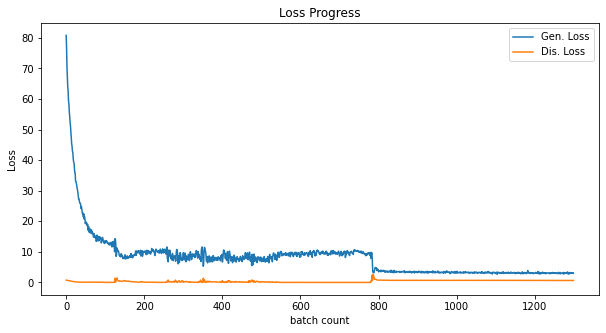

In [19]:
# Batch 데이터별 loss를 시각화 한다
plt.figure(figsize=(10,5))
plt.title('Loss Progress')
plt.plot(loss_hist['gen'], label='Gen. Loss')
plt.plot(loss_hist['dis'], label='Dis. Loss')
plt.xlabel('batch count')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
# 현재 모델의 가중치를 저장한다
path2models = './models/'
os.makedirs(path2models, exist_ok=True)
path2weights_gen = os.path.join(path2models, 'weights_gen.pt')
path2weights_dis = os.path.join(path2models, 'weights_dis.pt')

torch.save(model_gen.state_dict(), path2weights_gen)
torch.save(model_dis.state_dict(), path2weights_dis)

In [21]:
# 가중치를 불러와서 Generator가 생성한 가짜 이미지를 확인해보자
weights = torch.load(path2weights_gen)
model_gen.load_state_dict(weights)

# evalutaion mode
model_gen.eval()

# fake image 생성
with torch.no_grad():
  for a,b in train_dl: # 총 32개의 데이터가 반환된다
    fake_imgs = model_gen(a.to(device)).cpu() # 32개의 fake image
    real_imgs = b # 32개의 real image
    break

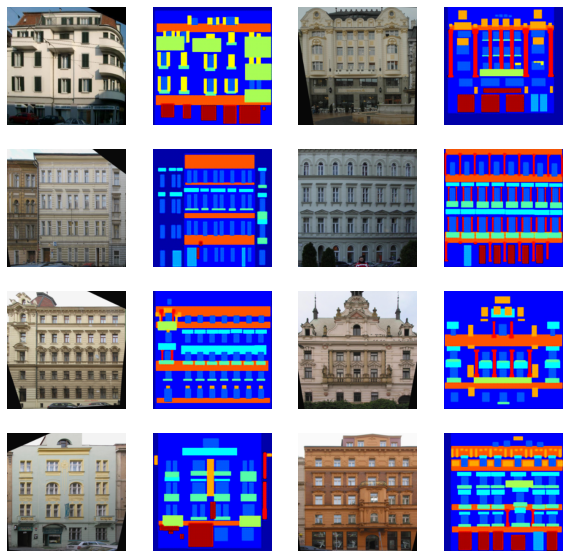

In [22]:
# 가짜 이미지 시각화
plt.figure(figsize=(10,10))

# 0 - 15인덱스의 이미지 중에서
# 0,2,4,6,8,10,12,14 인덱스의 가짜 이미지와 진짜 정답 이미지를 시각화한다
for ii in range(0,16,2):
    plt.subplot(4,4,ii+1)
    plt.imshow(to_pil_image(0.5*real_imgs[ii]+0.5)) 
    plt.axis('off')
    plt.subplot(4,4,ii+2)
    plt.imshow(to_pil_image(0.5*fake_imgs[ii]+0.5))
    plt.axis('off')